## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Необходимо решить задачу машинного обучения, направленную на автоматизацию бизнес процессов. Построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 


Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
taxi_data.loc[:, 'pickup_datetime'] = pd.to_datetime(taxi_data.loc[:, 'pickup_datetime'], format ='%Y-%m-%d %H:%M:%S')
print(taxi_data['pickup_datetime'].min())
print(taxi_data['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:39


Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [4]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Посмотрим на статистические характеристики некоторых признаков. 

In [5]:
print()
print('Количество уникальных таксопарков в данных:', taxi_data.loc[:, 'vendor_id'].nunique())
print()
taxi_data.describe()


Количество уникальных таксопарков в данных: 2



vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.


In [6]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_of_week
    
    df['pickup_day_of_week'] = df['pickup_day_of_week'].replace({0:'monday', 1:'tuesday', 2:'wednesday', 3:'thursday', 4:'friday', 5:'saturday', 6:'sunday'})
    return df
    
taxi_data = add_datetime_features(taxi_data)

print('В субботу было совершено', taxi_data[taxi_data['pickup_day_of_week'] == 'saturday']['pickup_day_of_week'].count(), 'поездок.')
print('В среднем в день совершается', round(taxi_data.shape[0]/taxi_data['pickup_date'].nunique()), 'поездок.')

В субботу было совершено 220868 поездок.
В среднем в день совершается 8015 поездок.



Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 


In [7]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

def add_holiday_features(taxi_data, holiday_data):
    
    holidays = np.array(holiday_data['date'].values)
    taxi_data['pickup_holiday'] = taxi_data['pickup_date'].apply(lambda x: 1 if str(x) in holidays else 0)

    return taxi_data

taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()

585.0

Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [8]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

def add_osrm_features(taxi_data, osrm_data):
    osrm_data = osrm_data.loc[:, ['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    
    new_data = taxi_data.merge(
        osrm_data,
        on = 'id',
        how = 'left'
    )
    return new_data

taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_date  \
0         40.765602                  N            455  2016-03-14   
1         40.731152                  N            663  2016-06-12   
2         40.710087                  N           2124  2016-01-19   
3         40.706718                  N            429  2016-04-06   
4         40.782520                  N            435  2016-03-26   

   pickup_hour pickup_day_of_week  pickup_holiday  total_distance  \
0           17             monday               0          2009.1   
1            0             sunday               0          2513.2   
2           11            tuesday               0         11060.8   
3           19          wednesday               0          1779.4   
4           13           saturday               0          1614.9   

   total_travel_time  number_of_steps  
0              164.9              5.0  
1              332.0              6.0  
2              767.6             16.0  
3              235.8              4.0  
4              140.1              5.0

In [9]:
round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())

372

In [10]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [11]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [12]:
def add_geographical_features(taxi_data):
    
    distance = []
    direction = []
    for i in range(len(taxi_data.index)):
        distance.append(get_haversine_distance(taxi_data.loc[i, 'pickup_latitude'], taxi_data.loc[i, 'pickup_longitude'], taxi_data.loc[i, 'dropoff_latitude'], taxi_data.loc[i, 'dropoff_longitude']))
        direction.append(get_angle_direction(taxi_data.loc[i, 'pickup_latitude'], taxi_data.loc[i, 'pickup_longitude'], taxi_data.loc[i, 'dropoff_latitude'], taxi_data.loc[i, 'dropoff_longitude']))
    taxi_data['haversine_distance'] = np.array(distance)
    taxi_data['direction'] = np.array(direction)
    return taxi_data

taxi_data = add_geographical_features(taxi_data)
round(taxi_data['haversine_distance'].median(), 2)

2.09

Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.


In [13]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(taxi_data):
    coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    pred = kmeans.predict(coords)
    pred = kmeans.labels_
    taxi_data['geo_cluster'] = pred
    return taxi_data

taxi_data = add_cluster_features(taxi_data)
taxi_data.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  pickup_date pickup_hour  \
0         40.765602                  N  ...   2016-03-14          17   
1         40.731152                  N  ...   2016-06-12           0   
2         40.710087                  N  ...   2016-01-19          11   
3         40.706718                  N  ...   2016-04-06          19   
4         40.782520                  N  ...   2016-03-26          13   

   pickup_day_of_week pickup_holiday  total_distance  total_travel_time  \
0              monday              0          2009.1              164.9   
1              sunday              0          2513.2              332.0   
2             tuesday              0         11060.8              767.6   
3           wednesday              0          1779.4              235.8   
4            saturday              0          1614.9              140.1   

   number_of_steps  haversine_distance   direction  geo_cluster  
0              5.0            1.498521   99.970196            9  
1              6.0            1.805507 -117.153768            4  
2             16.0            6.385098 -159.680165            4  
3              4.0            1.485498 -172.737700            4  
4              5.0            1.188588  179.473585            9  

[5 rows x 21 columns]

In [14]:
taxi_data['geo_cluster'].value_counts().tail(1)

2    2
Name: geo_cluster, dtype: int64

Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [15]:
weather_data = pd.read_csv('data/weather_data.csv')

def add_weather_features(taxi_data, weather_data):
    
    weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')
    taxi_data['date_&_hour'] = [(x, y) for x, y in zip(taxi_data['pickup_datetime'].dt.date, taxi_data['pickup_datetime'].dt.hour)]
    weather_data['date_&_hour'] = [(x, y) for x, y in zip(weather_data['time'].dt.date, weather_data['time'].dt.hour)]
    
    weather_data = weather_data.loc[:, ['date_&_hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']] 
    
    df = taxi_data.merge(
        weather_data,
        on = 'date_&_hour',
        how = 'left'
    )
    df.drop('date_&_hour', axis=1, inplace=True)
    return df

taxi_data = add_weather_features(taxi_data, weather_data) 

In [16]:
mask = taxi_data['events'] == 'Snow'
taxi_data[mask]['events'].count()

13126

In [17]:
taxi_data.loc[:, ['temperature', 'visibility', 'wind speed', 'precip', 'events']].isnull().mean()*100

temperature    0.824876
visibility     0.824876
wind speed     0.824876
precip         0.824876
events         0.824876
dtype: float64

Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам.


In [18]:
def fill_null_weather_data(taxi_data):
    cols_with_null = taxi_data.isnull().mean()
    cols_with_null = cols_with_null[cols_with_null > 0]
    for col in cols_with_null.index:
        if col == 'events':
            taxi_data[col] = taxi_data[col].fillna('None')
        else:
            taxi_data[col] = taxi_data[col].fillna(taxi_data.groupby('pickup_date')[col].transform('median'))
    return taxi_data

taxi_data = fill_null_weather_data(taxi_data)
taxi_data.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  total_travel_time  \
0         40.765602                  N  ...              164.9   
1         40.731152                  N  ...              332.0   
2         40.710087                  N  ...              767.6   
3         40.706718                  N  ...              235.8   
4         40.782520                  N  ...              140.1   

  number_of_steps  haversine_distance   direction  geo_cluster  temperature  \
0             5.0            1.498521   99.970196            9          4.4   
1             6.0            1.805507 -117.153768            4         28.9   
2            16.0            6.385098 -159.680165            4         -6.7   
3             4.0            1.485498 -172.737700            4          7.2   
4             5.0            1.188588  179.473585            9          9.4   

   visibility  wind speed  precip  events  
0         8.0        27.8     0.3    None  
1        16.1         7.4     0.0    None  
2        16.1        24.1     0.0    None  
3        16.1        25.9     0.0    None  
4        16.1         9.3     0.0    None  

[5 rows x 26 columns]

In [20]:
round(taxi_data['temperature'].median(), 1)

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


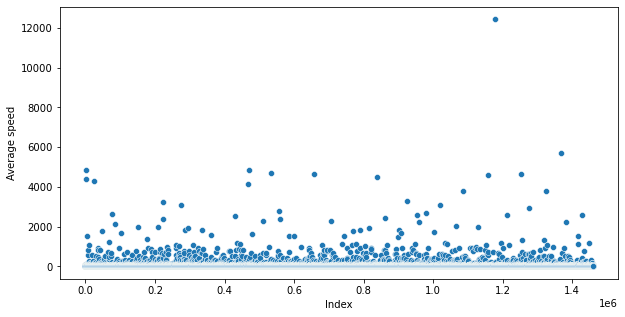

In [19]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 



Найдём поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

Найдём поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

In [20]:
mask = taxi_data['trip_duration'] > 24*3600
print(taxi_data.shape)
taxi_data.drop(taxi_data[mask].index, axis=0, inplace=True)
print(taxi_data.shape)

(1458644, 26)
(1458640, 26)


In [21]:
mask = (taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) > 300
print(len(taxi_data[mask]))
taxi_data[mask]

407


id  vendor_id     pickup_datetime     dropoff_datetime  \
842      id3263580          2 2016-05-21 12:46:46  2016-05-21 12:46:49   
1107     id0729156          2 2016-06-23 13:36:48  2016-06-23 13:36:50   
3305     id0210376          1 2016-05-10 14:08:36  2016-05-10 14:08:42   
5992     id3738922          1 2016-02-12 11:33:01  2016-02-12 11:33:09   
6777     id2891134          1 2016-05-16 08:20:40  2016-05-16 08:20:42   
...            ...        ...                 ...                  ...   
1426834  id1499313          1 2016-03-11 16:35:29  2016-03-11 16:35:37   
1427152  id2789597          1 2016-05-27 23:50:53  2016-05-27 23:50:57   
1433244  id2935356          2 2016-04-26 20:44:01  2016-04-26 20:44:05   
1447397  id0374193          1 2016-06-14 06:25:07  2016-06-14 06:25:19   
1454881  id1847851          2 2016-02-22 07:38:52  2016-02-22 07:38:56   

         passenger_count  pickup_longitude  pickup_latitude  \
842                    2        -73.782372        40.648766   
1107                   3        -73.827660        40.716175   
3305                   1        -73.796432        40.645237   
5992                   1        -73.781868        40.644676   
6777                   1        -73.963028        40.774895   
...                  ...               ...              ...   
1426834                1        -73.957596        40.758183   
1427152                1        -73.977936        40.748436   
1433244                1        -73.985100        40.768398   
1447397                1        -73.784531        40.646038   
1454881                1        -73.975182        40.755562   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
842             -73.782372         40.648746                  N  ...   
1107            -73.822113         40.711452                  N  ...   
3305            -73.797707         40.645401                  N  ...   
5992            -73.781822         40.644588                  N  ...   
6777            -73.963020         40.774891                  N  ...   
...                    ...               ...                ...  ...   
1426834         -73.957603         40.758183                  N  ...   
1427152         -73.977974         40.748463                  N  ...   
1433244         -73.985252         40.768749                  N  ...   
1447397         -73.786201         40.645290                  N  ...   
1454881         -73.973877         40.755661                  N  ...   

         total_travel_time number_of_steps  haversine_distance   direction  \
842                  316.6            16.0            0.002121  180.000000   
1107                 173.1             9.0            0.703065  138.321912   
3305                 272.0            12.0            0.109033  -80.369600   
5992                 189.9             4.0            0.010493  158.402515   
6777                  68.4             6.0            0.000770  123.435049   
...                    ...             ...                 ...         ...   
1426834              440.3            13.0            0.000643  -89.999998   
1427152               60.8             6.0            0.004375  -47.262314   
1433244              132.8             6.0            0.041085  -18.225840   
1447397              375.0            13.0            0.163658 -120.530238   
1454881               53.7             4.0            0.110441   84.268516   

         geo_cluster  temperature  visibility  wind speed  precip  events  
842                1         17.2        14.5         7.4     0.0    None  
1107               1         24.4        12.9         5.6     0.0    None  
3305               1         16.7        16.1         7.4     0.0    None  
5992               1         -7.2        16.1         7.4     0.0    None  
6777               9          8.0        16.1         0.0     0.0    None  
...              ...          ...         ...         ...     ...     ...  
1426834            9         17.2   

In [22]:
mask = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 > 300 
print(len(taxi_data[mask]))
print(taxi_data.shape)
taxi_data.drop(taxi_data[mask].index, axis=0, inplace=True)
print(taxi_data.shape)

407
(1458640, 26)
(1458233, 26)


## 3. Разведывательный анализ данных (EDA)

В этой части проекта:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [23]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построем гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным? 
Проверем свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

In [24]:
#fig = px.histogram(taxi_data['trip_duration_log'], marginal='box', height = 600)
#fig.show()

Судя по диаграмме распередение признака trip_duration_log является нормальным. ПРоверим эту гиппотизу при помощи теста.

In [25]:
H0 = 'Данные распределены нормально'
Ha = 'Данные распределены не нормально'

alpha = 0.05

_, p = stats.normaltest(taxi_data['trip_duration_log'])

if p > alpha:
    print(f'Принимаем нулевую гипотизу:', H0)
    print(f'P-value = {p}')
else:
    print('Отвергаем нулевую гипотизу:', Ha)
    print(f'P-value = {p}')

Отвергаем нулевую гипотизу: Данные распределены не нормально
P-value = 0.0


Построем визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 


In [26]:
#fig = px.histogram(taxi_data, 'trip_duration_log', color = 'vendor_id', marginal='box', height = 400)
#fig.show()


Независимо от таксопарка, структура распределния длительности поездки в логорифмическом масштабе практически идентичная.  

Построем визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

In [27]:
#fig = px.histogram(taxi_data, x='trip_duration_log', color='store_and_fwd_flag', height=600, marginal='box')
#fig.show()

<AxesSubplot:xlabel='trip_duration_log', ylabel='Count'>

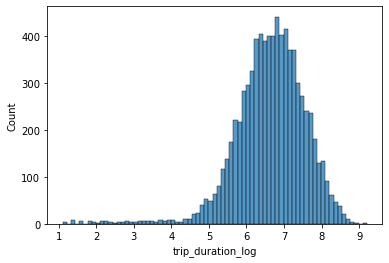

In [28]:
plt.Figure(figsize=(15,7))

sns.histplot(data = taxi_data[taxi_data['store_and_fwd_flag'] == 'Y'], x = 'trip_duration_log' )

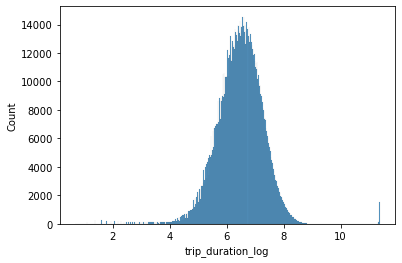

In [32]:
plt.Figure(figsize=(15,7))

sns.histplot(data = taxi_data[taxi_data['store_and_fwd_flag'] == 'N'], x = 'trip_duration_log');

Построем две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

In [33]:
#fig = px.histogram(taxi_data['pickup_datetime'].dt.hour, width = 1000, height = 300)
#fig.show()

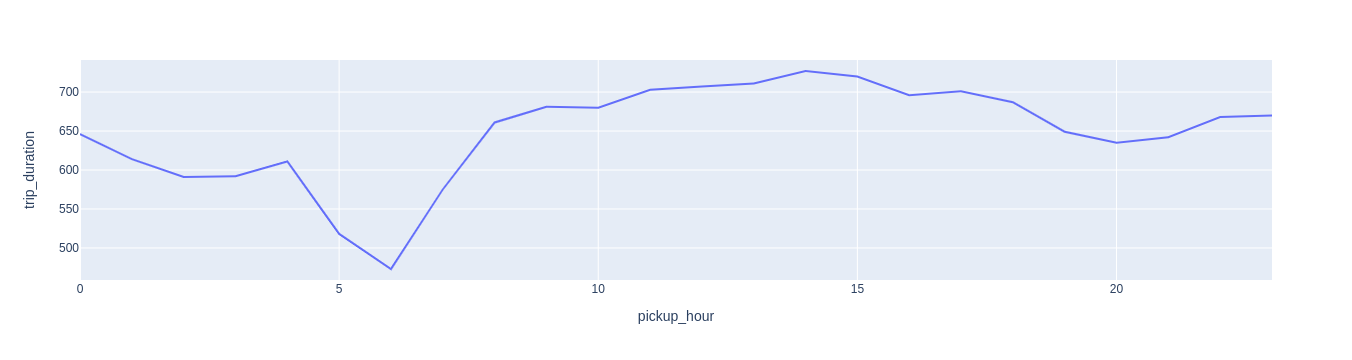

In [34]:
df = taxi_data.groupby(['pickup_hour'], as_index=False)[['pickup_hour', 'trip_duration']].median().rename({'trip_duration':'median_trip_duration'})
fig = px.line(df, x = 'pickup_hour', y = 'trip_duration')
fig.show()

Построем две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

In [1]:
#fig = px.histogram(taxi_data['pickup_day_of_week'])
#fig.show()

In [2]:
#df = taxi_data.groupby(['pickup_day_of_week'], as_index=False)[['pickup_day_of_week', 'trip_duration']].median().rename(columns = {'trip_duration': 'median_trip_duration'})

#fig = px.histogram(df, x = 'pickup_day_of_week', y = 'median_trip_duration')
#fig.show()

Посмотрим на обе временные характеристики одновременно. 

Построем сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

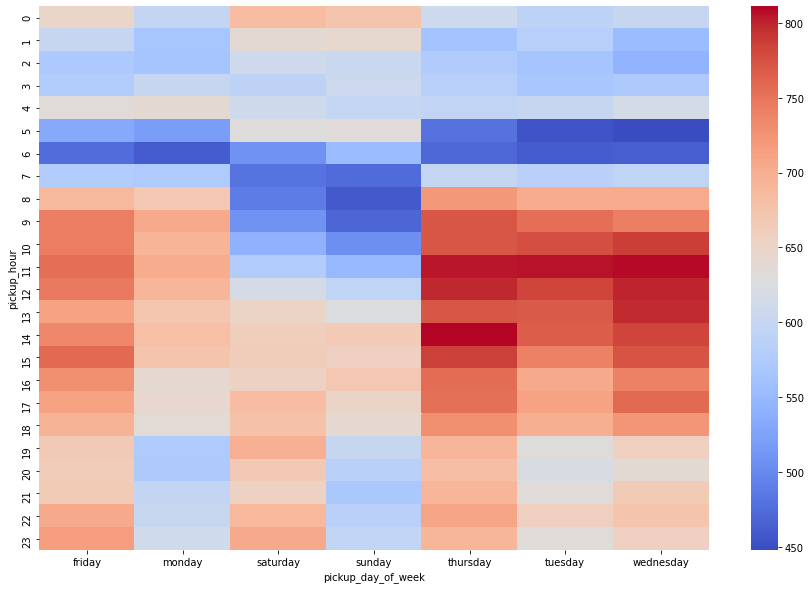

In [37]:
pivot = taxi_data.pivot_table(
    index = 'pickup_hour',
    columns = 'pickup_day_of_week',
    values = 'trip_duration',
    aggfunc = 'median'
)

plt.figure(figsize=(15,10))
sns.heatmap(pivot, cmap = 'coolwarm');

Построем две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

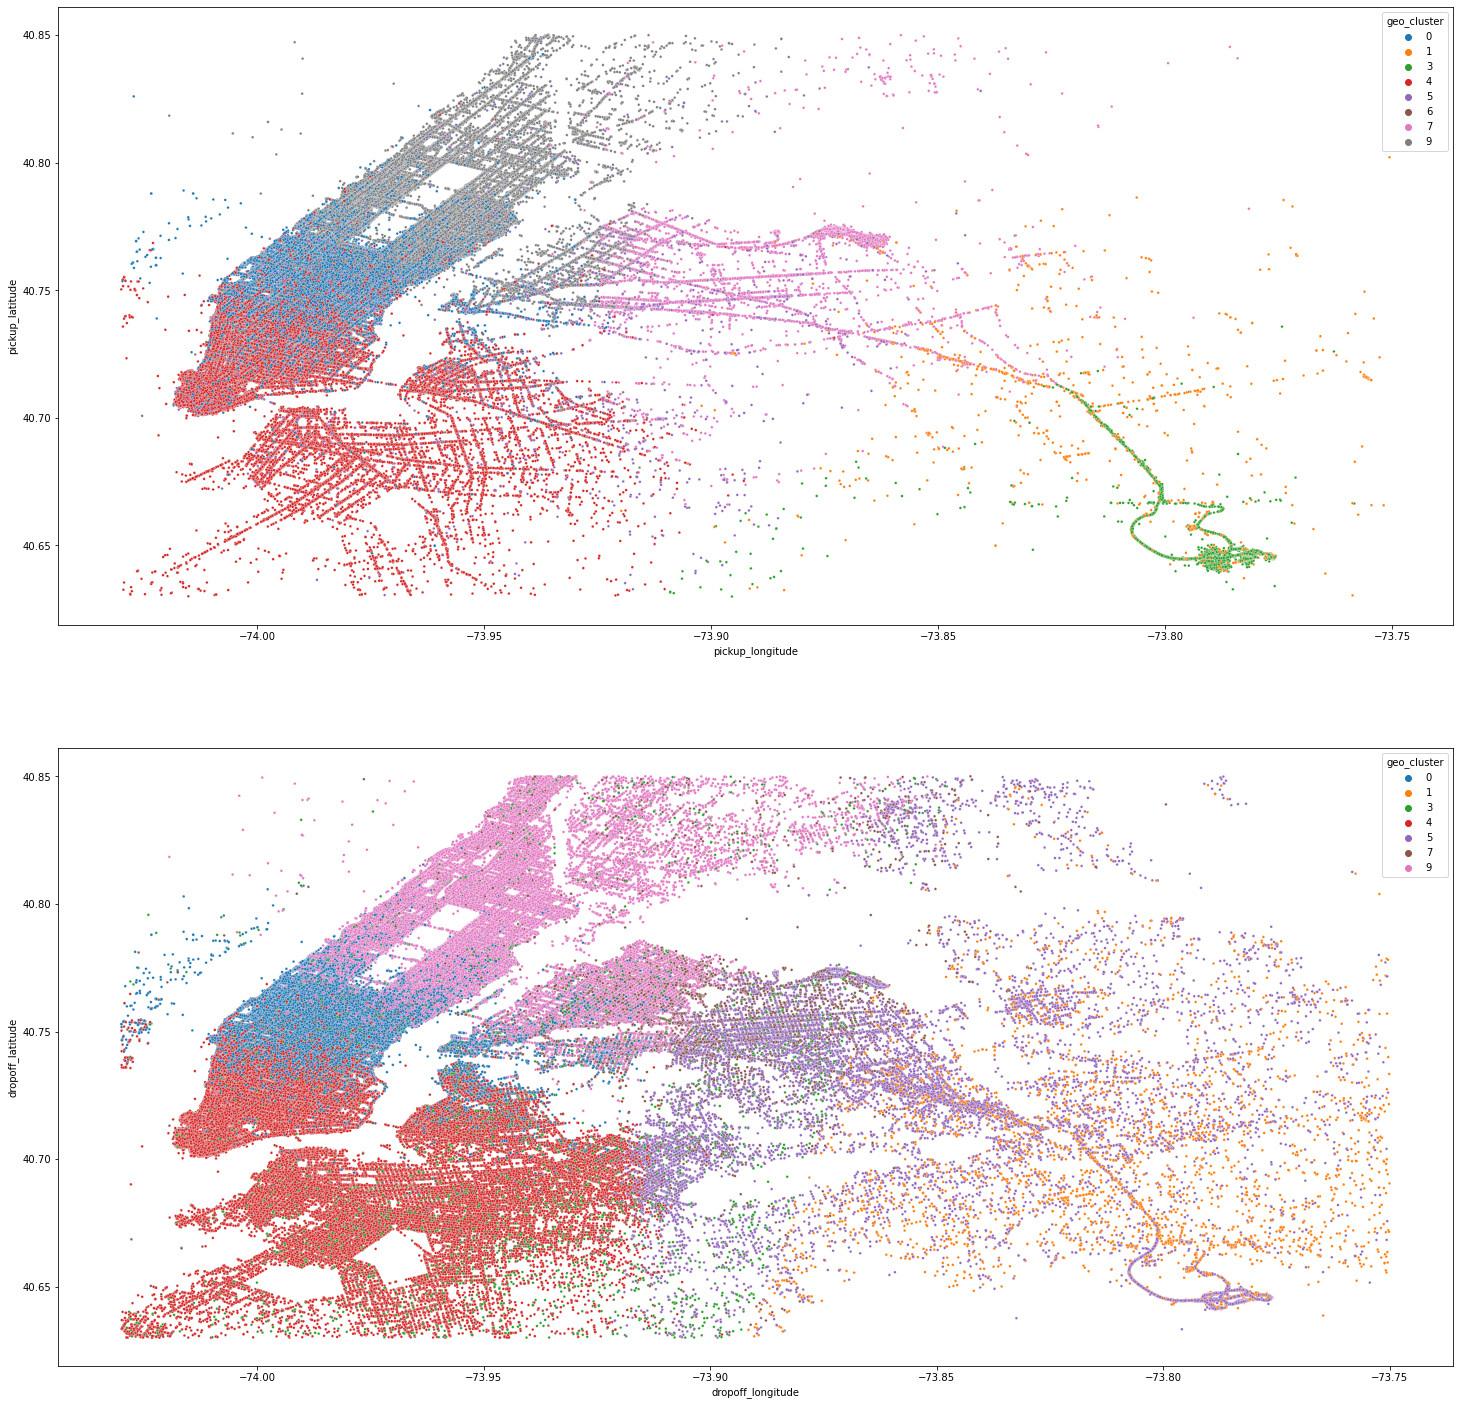

In [38]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)


mask_pickup_long = (taxi_data['pickup_longitude'] > city_long_border[0]) & (taxi_data['pickup_longitude'] < city_long_border[1])
mask_pickup_lat = (taxi_data['pickup_latitude'] > city_lat_border[0]) & (taxi_data['pickup_latitude'] < city_lat_border[1])
mask_dropoff_long = (taxi_data['dropoff_longitude'] > city_long_border[0]) & (taxi_data['dropoff_longitude'] < city_long_border[1])
mask_dropoff_lat = (taxi_data['dropoff_latitude'] > city_lat_border[0]) & (taxi_data['dropoff_latitude'] < city_lat_border[1])

fig, axes = plt.subplots(2, 1, figsize=(25,25))
scatter_pickup = sns.scatterplot(data = taxi_data[mask_pickup_long & mask_pickup_lat], x = 'pickup_longitude', y = 'pickup_latitude', hue = 'geo_cluster', s=7, palette='tab10', ax = axes[0])
#sns.color_palette('husl')

scatter_dropoff = sns.scatterplot(data = taxi_data[mask_dropoff_long & mask_dropoff_lat], x = 'dropoff_longitude', y = 'dropoff_latitude', hue = 'geo_cluster', s=7, palette='tab10', ax=axes[1])


## 4. Отбор и преобразование признаков

In [39]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [40]:
train_data = pd.read_csv('taxi_data_copy.csv')
train_data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  number_of_steps  \
0         40.765602                  N  ...              5.0   
1         40.731152                  N  ...              6.0   
2         40.710087                  N  ...             16.0   
3         40.706718                  N  ...              4.0   
4         40.782520                  N  ...              5.0   

  haversine_distance   direction geo_cluster  temperature  visibility  \
0           1.498521   99.970196           9          4.4         8.0   
1           1.805507 -117.153768           4         28.9        16.1   
2           6.385098 -159.680165           4         -6.7        16.1   
3           1.485498 -172.737700           4          7.2        16.1   
4           1.188588  179.473585           9          9.4        16.1   

   wind speed  precip  events  trip_duration_log  
0        27.8     0.3    None           6.122493  
1         7.4     0.0    None           6.498282  
2        24.1     0.0    None           7.661527  
3        25.9     0.0    None           6.063785  
4         9.3     0.0    None           6.077642  

[5 rows x 27 columns]

In [41]:
train_data = taxi_data.copy()
train_data.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  number_of_steps  \
0         40.765602                  N  ...              5.0   
1         40.731152                  N  ...              6.0   
2         40.710087                  N  ...             16.0   
3         40.706718                  N  ...              4.0   
4         40.782520                  N  ...              5.0   

  haversine_distance   direction geo_cluster  temperature  visibility  \
0           1.498521   99.970196           9          4.4         8.0   
1           1.805507 -117.153768           4         28.9        16.1   
2           6.385098 -159.680165           4         -6.7        16.1   
3           1.485498 -172.737700           4          7.2        16.1   
4           1.188588  179.473585           9          9.4        16.1   

   wind speed  precip  events  trip_duration_log  
0        27.8     0.3    None           6.122493  
1         7.4     0.0    None           6.498282  
2        24.1     0.0    None           7.661527  
3        25.9     0.0    None           6.063785  
4         9.3     0.0    None           6.077642  

[5 rows x 27 columns]

In [42]:
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)
train_data.shape

(1458233, 25)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [43]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

In [44]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 1 if x == 2 else 0)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

print(round(train_data['vendor_id'].mean(), 2))
print(round(train_data['store_and_fwd_flag'].mean(), 3))

0.53
0.006


In [45]:
nunique = [] 
for col in train_data.columns:
    nunique.append(train_data[col].nunique())
    
df = pd.DataFrame(nunique, index = train_data.columns, columns=['nunique'])
df.sort_values('nunique')#.plot(kind='bar')

nunique
vendor_id                 2
store_and_fwd_flag        2
pickup_holiday            2
events                    4
pickup_day_of_week        7
passenger_count          10
geo_cluster              10
visibility               17
wind speed               22
pickup_hour              24
precip                   28
number_of_steps          43
temperature             124
trip_duration_log      7413
trip_duration          7413
total_travel_time     19438
pickup_longitude      23014
dropoff_longitude     33801
pickup_latitude       45219
dropoff_latitude      62503
total_distance       197214
direction           1451647
haversine_distance  1451907

Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, pickup_dropoff_cluster и events в таблице train_data с помощью OneHotEndoder() из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

In [46]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

encoder = preprocessing.OneHotEncoder(drop='first')

data_onehot = encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = encoder.get_feature_names(columns_to_change)

data_onehot = pd.DataFrame(data_onehot, columns=column_names)

print(data_onehot.shape)


(1458233, 18)


/home/vadym/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Добавим полученную таблицу с закодированными признаками:

In [47]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [48]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [49]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

С помощью SelectKBest отберём 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.


In [50]:
from sklearn.feature_selection import f_regression

k_best = feature_selection.SelectKBest(score_func=f_regression, k=25)
k_best.fit(X_train, y_train_log)
X_train_new = k_best.transform(X_train)
X_valid_new = k_best.transform(X_valid)
kbest_columns = k_best.get_feature_names_out()

X_train_best = pd.DataFrame(X_train_new, columns = kbest_columns)
X_valid_best = pd.DataFrame(X_valid_new, columns = kbest_columns)
X_train_best.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0        1.0              5.0        -73.958717        40.775002   
1        1.0              1.0        -73.958954        40.780697   
2        1.0              1.0        -73.993469        40.747169   
3        1.0              1.0        -73.984970        40.753571   
4        1.0              1.0        -73.956215        40.778744   

   dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_hour  \
0         -73.966599         40.773041                 0.0         17.0   
1         -73.940643         40.805672                 0.0          7.0   
2         -74.002518         40.734200                 0.0         11.0   
3         -74.011551         40.712910                 0.0         15.0   
4         -73.957932         40.776211                 0.0         18.0   

   pickup_holiday  total_distance  ...  pickup_day_of_week_saturday  \
0             0.0           979.9  ...                          0.0   
1             0.0          3177.4  ...                          0.0   
2             0.0          1632.2  ...                          1.0   
3             0.0          7558.5  ...                          0.0   
4             0.0           316.6  ...                          0.0   

   pickup_day_of_week_sunday  pickup_day_of_week_thursday  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        1.0                          0.0   

   pickup_day_of_week_tuesday  pickup_day_of_week_wednesday  geo_cluster_1  \
0                         0.0                           1.0            0.0   
1                         1.0                           0.0            0.0   
2                         0.0                           0.0            0.0   
3                         0.0                           1.0            0.0   
4                         0.0                           0.0            0.0   

   geo_cluster_3  geo_cluster_5  geo_cluster_7  geo_cluster_9  
0            0.0            0.0            0.0            1.0  
1            0.0            0.0            0.0            1.0  
2            0.0            0.0            0.0            0.0  
3            0.0            0.0            0.0            0.0  
4            0.0            0.0            0.0            1.0  

[5 rows x 25 columns]

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_best)

#X_train_scaled = scaler.transform(X_train_best)
X_valid_scaled = scaler.transform(X_valid_best)

np.round(np.mean(X_valid_scaled[:, 0]), 2)

0.54

Построем модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставим по умолчанию.

In [52]:
l_model = linear_model.LinearRegression()

l_model.fit(X_train_scaled, y_train_log)

y_train_pred = l_model.predict(X_train_scaled)
y_valid_pred = l_model.predict(X_valid_scaled)

print(round(metrics.mean_squared_error(y_train_pred, y_train_log)**0.5, 2))
print(round(metrics.mean_squared_error(y_valid_pred, y_valid_log)**0.5, 2))

0.54
0.54


Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставим в значение False.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)

lr_model_poly = linear_model.LinearRegression()

lr_model_poly.fit(X_train_scaled_poly, y_train_log)

y_train_pred = lr_model_poly.predict(X_train_scaled_poly)
y_valid_pred = lr_model_poly.predict(X_valid_scaled_poly)

print(round(metrics.mean_squared_error(y_train_pred, y_train_log)**0.5, 2))
print(round(metrics.mean_squared_error(y_valid_pred, y_valid_log)**0.5, 2))

Построем модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

In [43]:
from sklearn.linear_model import Ridge

ridge_model = linear_model.Ridge(alpha=1)
ridge_model.fit(X_train_scaled_poly, y_train_log)

y_train_scaled_poly = ridge_model.predict(X_train_scaled_poly)
y_valid_scaled_poly = ridge_model.predict(X_valid_scaled_poly)

print(round(metrics.mean_squared_error(y_train_scaled_poly, y_train_log)**0.5, 2))
print(round(metrics.mean_squared_error(y_valid_scaled_poly, y_valid_log)**0.5, 2))


0.48
0.48


Построем модель дерева решений (DecisionTreeRegressor) на обучающей выборке

In [44]:
tree_model = tree.DecisionTreeRegressor()

tree_model.fit(X_train_scaled, y_train_log)

y_train_pred = tree_model.predict(X_train_scaled)
y_valid_pred = tree_model.predict(X_valid_scaled)

print(metrics.mean_squared_error(y_train_pred, y_train_log)**0.5)
print(metrics.mean_squared_error(y_valid_pred, y_valid_log)**0.5)

0.0030491915836393033
0.5651241528817539


Переберём все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

In [45]:
max_depth = range(7, 20)

RMSE_train = []
RMSE_valid = []

for i in max_depth:
    tree_model = tree.DecisionTreeRegressor(max_depth = i)
    tree_model.fit(X_train_scaled, y_train_log)
    
    y_train_pred = tree_model.predict(X_train_scaled)
    y_valid_pred = tree_model.predict(X_valid_scaled)
    
    RMSE_train.append(metrics.mean_squared_error(y_train_pred, y_train_log)**0.5)
    RMSE_valid.append(metrics.mean_squared_error(y_valid_pred, y_valid_log)**0.5)
    
rmse_df = pd.DataFrame([np.array(RMSE_train).T, np.array(RMSE_valid).T], columns = max_depth)
rmse_df = rmse_df.T.rename(columns={0:'RMSE_train', 1:'RMSE_valid'})

rmse_df

RMSE_train  RMSE_valid
7     0.444822    0.447174
8     0.437048    0.440817
9     0.430022    0.435993
10    0.422599    0.431723
11    0.414765    0.430191
12    0.406102    0.430056
13    0.395788    0.432458
14    0.384035    0.438417
15    0.370728    0.444712
16    0.356135    0.452752
17    0.339915    0.462928
18    0.322885    0.472145
19    0.304601    0.482307

In [3]:
#fig = px.line(rmse_df, title = 'RMSLE valid & train lineplot')
#fig.show()

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

In [47]:
tree_model = ensemble.RandomForestRegressor(
    n_estimators = 200,
    max_depth = 12, 
    criterion = 'squared_error',
    min_samples_split = 20,
    random_state = 42,
    verbose = True
)

tree_model.fit(X_train_scaled, y_train_log)

y_train_pred = tree_model.predict(X_train_scaled)
y_valid_pred = tree_model.predict(X_valid_scaled)

print(round(metrics.mean_squared_error(y_train_pred, y_train_log)**0.5, 2))
print(round(metrics.mean_squared_error(y_valid_pred, y_valid_log)**0.5, 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 24.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.4
0.41


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.9s finished


In [48]:
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True
)

gb.fit(X_train_scaled, y_train_log)

y_train_pred = gb.predict(X_train_scaled)
y_valid_pred = gb.predict(X_valid_scaled)

print(round(metrics.mean_squared_error(y_train_pred, y_train_log)**0.5, 2))
print(round(metrics.mean_squared_error(y_valid_pred, y_valid_log)**0.5, 2))

      Iter       Train Loss   Remaining Time 
         1           0.3110           10.48m
         2           0.2247           10.35m
         3           0.1987           10.28m
         4           0.1875           10.16m
         5           0.1821           10.05m
         6           0.1789            9.92m
         7           0.1742            9.80m
         8           0.1721            9.69m
         9           0.1705            9.55m
        10           0.1694            9.45m
        20           0.1585            8.36m
        30           0.1532            7.30m
        40           0.1500            6.23m
        50           0.1468            5.19m
        60           0.1439            4.15m
        70           0.1421            3.11m
        80           0.1402            2.07m
        90           0.1383            1.04m
       100           0.1371            0.00s
0.37
0.39


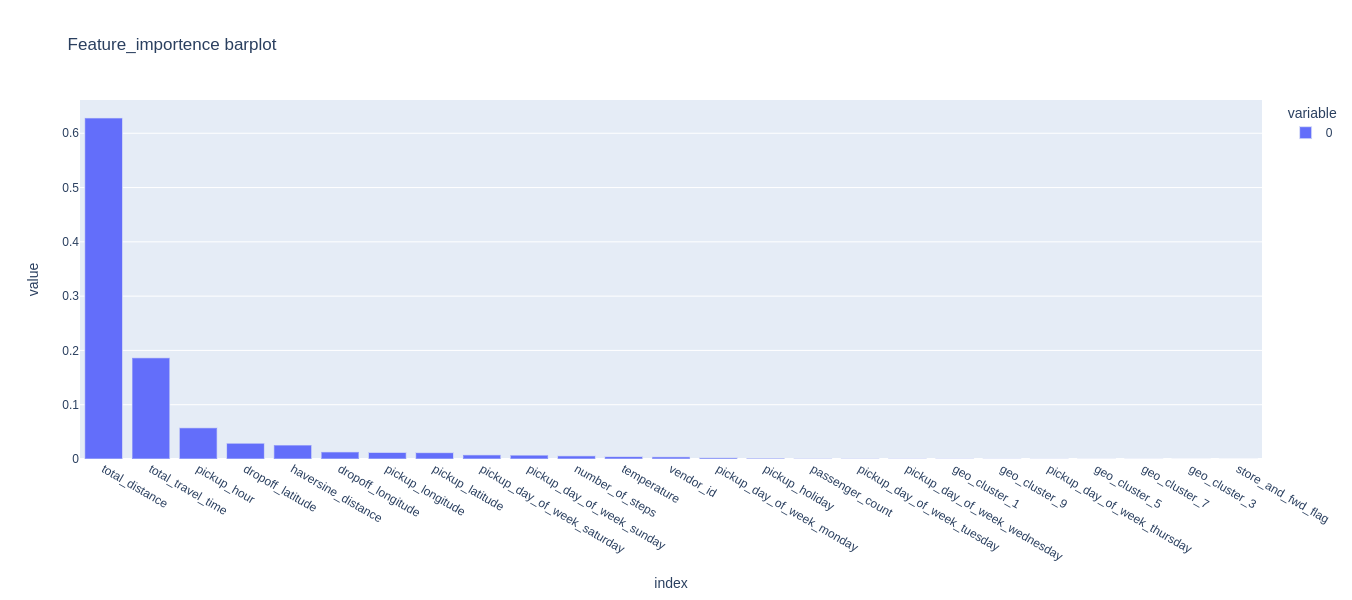

In [49]:
gb.feature_importances_
kbest_columns
fea_imp = pd.Series(gb.feature_importances_, kbest_columns)

fea_imp = fea_imp.sort_values(ascending=False)

fig = px.bar(fea_imp, height = 600, title = 'Feature_importence barplot')
fig.show()

In [50]:
print(round(metrics.mean_squared_error(y_train_pred, y_train_log)**0.5, 2))
print(round(metrics.mean_squared_error(y_valid_pred, y_valid_log)**0.5, 2))

0.37
0.39


In [51]:
print(round(metrics.median_absolute_error(np.exp(y_valid_pred)-1, np.exp(y_valid_log)-1)/60, 1))

1.8


In [53]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

In [57]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data) 

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

TypeError: could not convert string to float: 'None'

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)